## Create I/O Data

In [1]:
from utils.labels_utils import get_all_files_mhd
all_files_mhd = get_all_files_mhd("/data/Riabova/train/train_depth_0_70/")
len(all_files_mhd)

110

In [2]:
from utils.type_reader import mha_read_header
from utils.labels_utils import get_labels
import numpy as np
from tqdm import tqdm

# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
labels = np.empty((1, 3))
i = 0
for f in all_files_mhd:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    info = mha_read_header(f)
    
    # only leave frames with z = [5, ..., 8] and only frames 5-40
    # start_frame = 5
    # to_frame = 40
    # step_frame = 5
    
    filename = f.split("/")[-1].split(".")[0]
    filename_params = filename.split('_')
    z = int(filename_params[2])
    if (z > 8):
        continue
    
    new_labels = get_labels(f, info)
    # labels = np.concatenate((labels, new_labels[start_frame:to_frame:step_frame, :]), axis = 0)
    labels = np.concatenate((labels, new_labels), axis = 0)
    # all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*int((to_frame-start_frame)/step_frame)), axis=0) 
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*info['Dimensions'][3]), axis=0)
    # frame_nums = np.concatenate((frame_nums, np.arange(start_frame, to_frame, step_frame)), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, info['Dimensions'][3])), axis=0)

    i+=1
    
all_frames_filenames_array = all_frames_filenames_array[ 1:]
labels = labels[1:, :]
frame_nums = frame_nums[1:]

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...


In [3]:
X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
y = labels
print(X[0, :])
print(y[0, :])

['/data/Riabova/train/train_depth_0_70/10_0_-3_0_0_0_4_2_1689851213927661.mhd'
 '0.0']
[ 99.57817325 109.4948     125.6625    ]


In [5]:
y.shape[0]

2356

In [4]:
from miscnn.data_loading.interfaces import Dictionary_interface
from utils.ImageDataset import getDatapointResized
from miscnn import Data_IO
import numpy as np
from tqdm import tqdm

# Create data set (grayscale image with binary mask)
dataset3D = dict()
for i in tqdm(range(0, 20)): # range(0, y.shape[0]):
    img, mask, us_tip_coords_resized = getDatapointResized(X[i, 0], int(float(X[i, 1])), y[i], mask_diam=3, resizeTo=128)
    dataset3D["TEST.sample_" + str(i)] = (img, mask)
    
# Initialize Dictionary IO Interface
io_interface3D = Dictionary_interface(dataset3D, channels = 1, classes=2, three_dim=True)

# Create the Data I/O object
data_io = Data_IO(io_interface3D, input_path="")

100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


### Explore Data_IO

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Load the first sample via MIScnn data loader
sample_list = data_io.get_indiceslist()
sample_test = data_io.sample_loader(sample_list[0], load_seg=True)

In [6]:
# Get the index of the needle tip and plot in this plane
nz_indices = np.nonzero(sample_test.seg_data[:, :, :, 0])
z_mean = int(np.mean(nz_indices[2]))

/data/Riabova/masterarbeit/data/Riabova/miniconda3/envs/masterarbeit/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/Riabova/masterarbeit/data/Riabova/miniconda3/envs/masterarbeit/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

Shape of image: (128, 128, 128, 1)


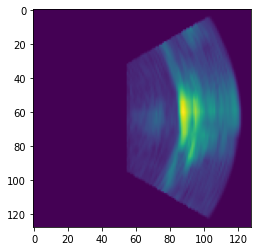

In [8]:
# Visualize the image
img_data = sample_test.img_data
print("Shape of image:", img_data.shape)
plt.imshow(img_data[:, :, z_mean, 0])

Shape of segmentation: (128, 128, 128, 1)


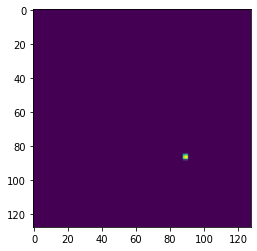

In [9]:
# Visualize the ground truth segmentation
seg_data = sample_test.seg_data * 255
print("Shape of segmentation:", seg_data.shape)
plt.imshow(seg_data[:, :, z_mean, 0])

### Preprocess Data_IO an feed to network

In [10]:
import miscnn
from miscnn.neural_network.architecture.unet.standard import Architecture

# Create a Preprocessor instance to configure how to preprocess the data into batches
pp = miscnn.Preprocessor(data_io, batch_size=10, analysis="fullimage", use_multiprocessing=False)

# Create a deep learning neural network model with a standard U-Net architecture
unet_standard = Architecture()
model = miscnn.Neural_Network(preprocessor=pp, architecture=unet_standard)

/home/Riabova/miniconda3/envs/masterarbeit/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d (Conv3D)                (None, None, None,   896         ['input_1[0][0]']                
                                None, 32)                                                         
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   128        ['conv3d[0][0]']                 
 alization)                     None, 32)                                                     

In [12]:
# Training the model with 400 samples for 100 epochs
sample_list = data_io.get_indiceslist()
model.train(sample_list[0:20], epochs=1)

: 

: 

In [ ]:
# Predict the segmentation for 20 samples
pred = model.predict(sample_list[400:500], return_output=True)